In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy import ndimage
import glob
from matplotlib.pyplot import cm 
from IPython.display import display, Math, Latex
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
import math

%matplotlib inline

### The dataset is acquired at https://github.com/OlgaBelitskaya/deep_learning_projects

In [2]:
path = 'letters/'

In [3]:
# Listing the images
filenames = glob.glob(path+'*.png')
# for i in range(1, 34):
#     t = str(i)+'_'
#     if i < 10:
#         t = '0' + t
#     f = filter(lambda x: t in x, glob.glob(path + '*.png'))
#     print len(f), f[0]

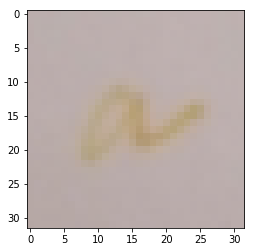

In [4]:
# Samples of the images
im_frame = Image.open(filenames[0])
np_frame = np.array(im_frame.getdata())
np_frame = np.delete(np_frame, 3, 1).reshape(32, 32, 3)
plt.imshow(np_frame, interpolation='nearest')

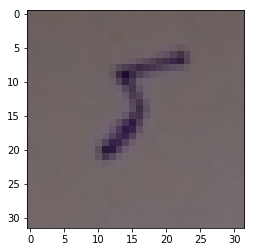

In [5]:
im_frame = Image.open(filenames[200])
np_frame = np.array(im_frame.getdata())
np_frame = np.delete(np_frame, 3, 1).reshape(32, 32, 3)
plt.imshow(np_frame, interpolation='nearest')

# -----------------------------------------------------------------------------------------------------------
# Global histograms per color

In [6]:
# Building RGB-vectors from images
def get_vector(filename):
    im_frame = Image.open(filename)
    np_frame = np.array(im_frame.getdata())
    np_frame = np.delete(np_frame, 3, 1)
    return np_frame

vectors = map(get_vector, filenames)
vectors = map(np.transpose, vectors)

In [7]:
# Extracting colors for histograms
red = map(lambda vector: vector[0], vectors)
green = map(lambda vector: vector[1], vectors)
blue = map(lambda vector: vector[2], vectors)

r = red[0]
for i in range(1, len(red)):
    r = np.append(r, red[i])
    
g = green[0]
for i in range(1, len(green)):
    g = np.append(g, green[i])
    
b = blue[0]
for i in range(1, len(blue)):
    b = np.append(b, blue[i])

In [8]:
def plot_histo(data, color):
    hist, bins = np.histogram(data, bins = 255)
    plt.bar(bins[:-1], hist, width = 1, color = color)
    plt.xlim(min(bins), max(bins))
    plt.plot(-10, 0, 'w', label = r'$\mu_'+color+ '=$' + str(round(np.mean(data), 4)))
    plt.plot(-10, 0, 'w', label = r'$\sigma_'+color+'=$' + str(round(np.std(data), 4)))
    leg = plt.legend(fontsize = 15)

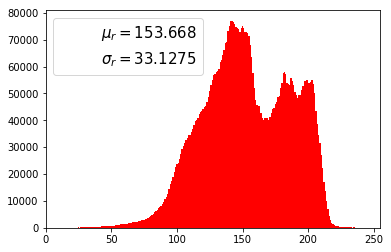

In [9]:
plot_histo(r, 'r')

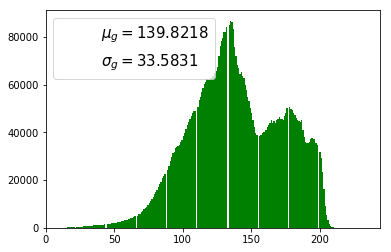

In [10]:
plot_histo(g, 'g')

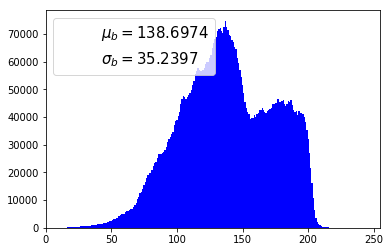

In [11]:
plot_histo(b, 'b')

# -----------------------------------------------------------------------------------------------------------
# Images of the global mean and standard deviation of the brightness

In [12]:
# Building grey vectors from images
def grey_vector(filename):
    im_frame = Image.open(filename)
    np_frame = np.array(im_frame.getdata())
    np_frame = np.delete(np_frame, 3, 1)
    np_frame = np.mean(np_frame, axis = 1).astype(int)
    return np_frame

vectors = map(grey_vector, filenames)
vectors = zip(*vectors)

In [13]:
v_mean = map(np.mean, vectors)
v_std = map(np.std, vectors)

v_mean = 255*(v_mean - min(v_mean)) / (max(v_mean) - min(v_mean))
v_std = 255*(v_std - min(v_std)) / (max(v_std) - min(v_std))

v_mean = np.asarray(zip(list(v_mean), list(v_mean), list(v_mean))).astype(int).reshape(32, 32, 3)
v_std = np.asarray(zip(list(v_std), list(v_std), list(v_std))).astype(int).reshape(32, 32, 3)

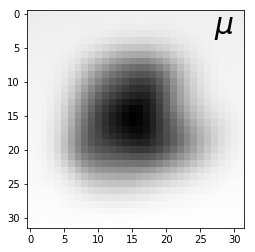

In [14]:
plt.imshow(v_mean, interpolation='nearest')
text = plt.text(27, 3, r'$\mu$', fontsize = 30)

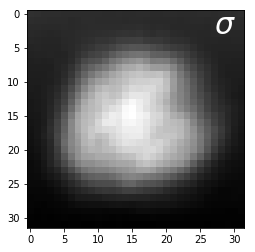

In [15]:
plt.imshow(v_std, interpolation='nearest')
text = plt.text(27, 3, r'$\sigma$', color = 'w', fontsize = 30)

# -----------------------------------------------------------------------------------------------------------
# Preprocessing

In [16]:
# Plotting gray-scale images
def plot_grey(vector):
    vector = np.transpose(np.stack((vector, vector, vector)))
    vector = np.reshape(vector, (32, 32, 3))
    plt.imshow(vector, interpolation = 'nearest') 
    
def plot_original(filename):
    im_frame = Image.open(filename)
    np_frame = np.array(im_frame.getdata())
    np_frame = np.delete(np_frame, 3, 1).reshape(32, 32, 3)
    plt.imshow(np_frame, interpolation='nearest')

In [17]:
# Preprocessing
def preprocess(filename):
    im_frame = Image.open(filename)
    np_frame = np.array(im_frame.getdata())
    np_frame = np.delete(np_frame, 3, 1)
    np_frame = np.mean(np_frame, axis = 1).astype(int)
    np.place(np_frame, np_frame < np.median(np_frame) - 1.5*np.std(np_frame), 0)
    np.place(np_frame, np_frame > np.median(np_frame) - 1.5*np.std(np_frame), 255)
    return np_frame

vectors = map(preprocess, filenames)

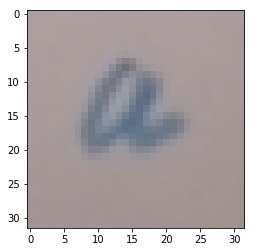

In [18]:
plot_original(filenames[1])

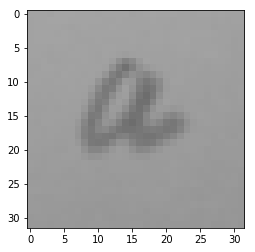

In [19]:
vv2 = grey_vector(filenames[1])
plot_grey(vv2)

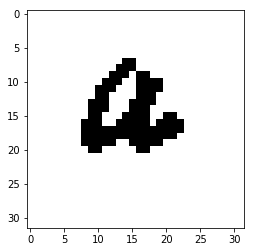

In [20]:
vv = preprocess(filenames[1])
plot_grey(vv)

In [21]:
print len(vectors), vectors[0]

5940 [255 255 255 ... 255 255 255]


# -----------------------------------------------------------------------------------------------------------
# Dimensionality reduction

In [22]:
X = np.asarray(vectors)

In [23]:
X.shape

(5940L, 1024L)

In [24]:
# Projecting the data to two components maximizing the variance
transformation = PCA(n_components = 2)
two_components = transformation.fit_transform(X)

In [25]:
# Checking how much variance is explained with the first two principal components
print("Variance explained by the first and second components\n", transformation.explained_variance_ratio_)

('Variance explained by the first and second components\n', array([0.05543501, 0.04336245]))


In [26]:
# Number of letters
n_letters = 33

In [27]:
# Function to plot the components and corresponding labels
def plot_components(two_components, x_label, y_label, n_letters):
    fig, ax = plt.subplots(figsize = (18, 13))
    plt.xlim(min(np.transpose(two_components)[1]), max(2*np.transpose(two_components)[1]))
    color=cm.rainbow(np.linspace(0, 1, n_letters))

    for y, c in zip(range(n_letters), color):
        xy = np.transpose(two_components[y*180:(y+1)*180])
        ax.scatter(list(xy[0]), list(xy[1]), c = c, label = y, alpha = 0.7)
        
    plt.xlabel(x_label, fontsize = 25)
    plt.ylabel(y_label, fontsize = 25)
    ax.legend(fontsize = 23, ncol = 2, loc = 5)
    ax.grid(True)

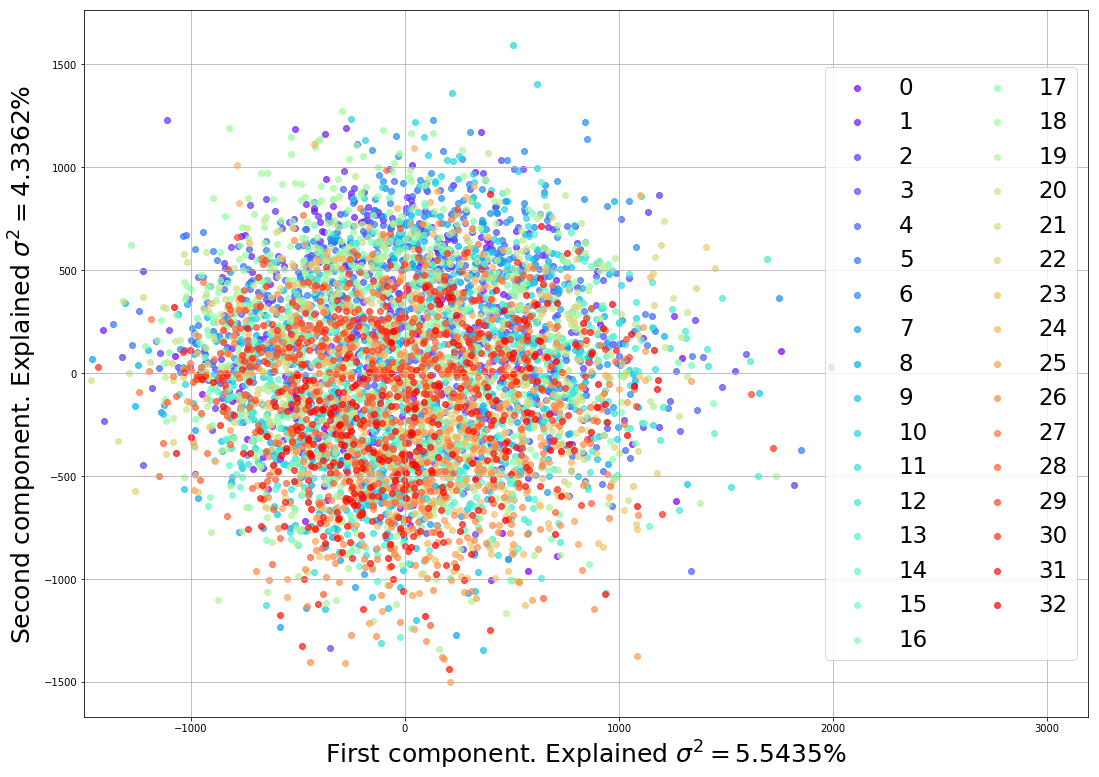

In [28]:
# Plotting everything
plot_components(two_components, 
                'First component. Explained ' + r'$\sigma^{2} = $' + \
                str(round(100*transformation.explained_variance_ratio_[0], 4)) + '%',
                'Second component. Explained ' + r'$\sigma^{2} = $' + \
                str(round(100*transformation.explained_variance_ratio_[1], 4)) + '%',
               n_letters)

In [29]:
# Projecting the data to 1024 components maximizing the variance
transformation = PCA(n_components = len(X[0]))
n_components = transformation.fit_transform(X)

In [30]:
# Calculating cumulative variance explained by the components
explained = transformation.explained_variance_ratio_.cumsum()

In [31]:
# Function to plot the components and corresponding labels
def plot_variances(variances, x_label, y_label):
    fig, ax = plt.subplots(figsize = (18, 18))
    plot = ax.plot(range(len(variances)), variances, linewidth = 8)
    plt.xlabel(x_label, fontsize = 25)
    plt.ylabel(y_label, fontsize = 25)
    plt.xticks(range(0, len(variances)+1, 16), rotation = 90, fontsize = 14)
    plt.yticks(fontsize = 14)
    ax.grid(True)

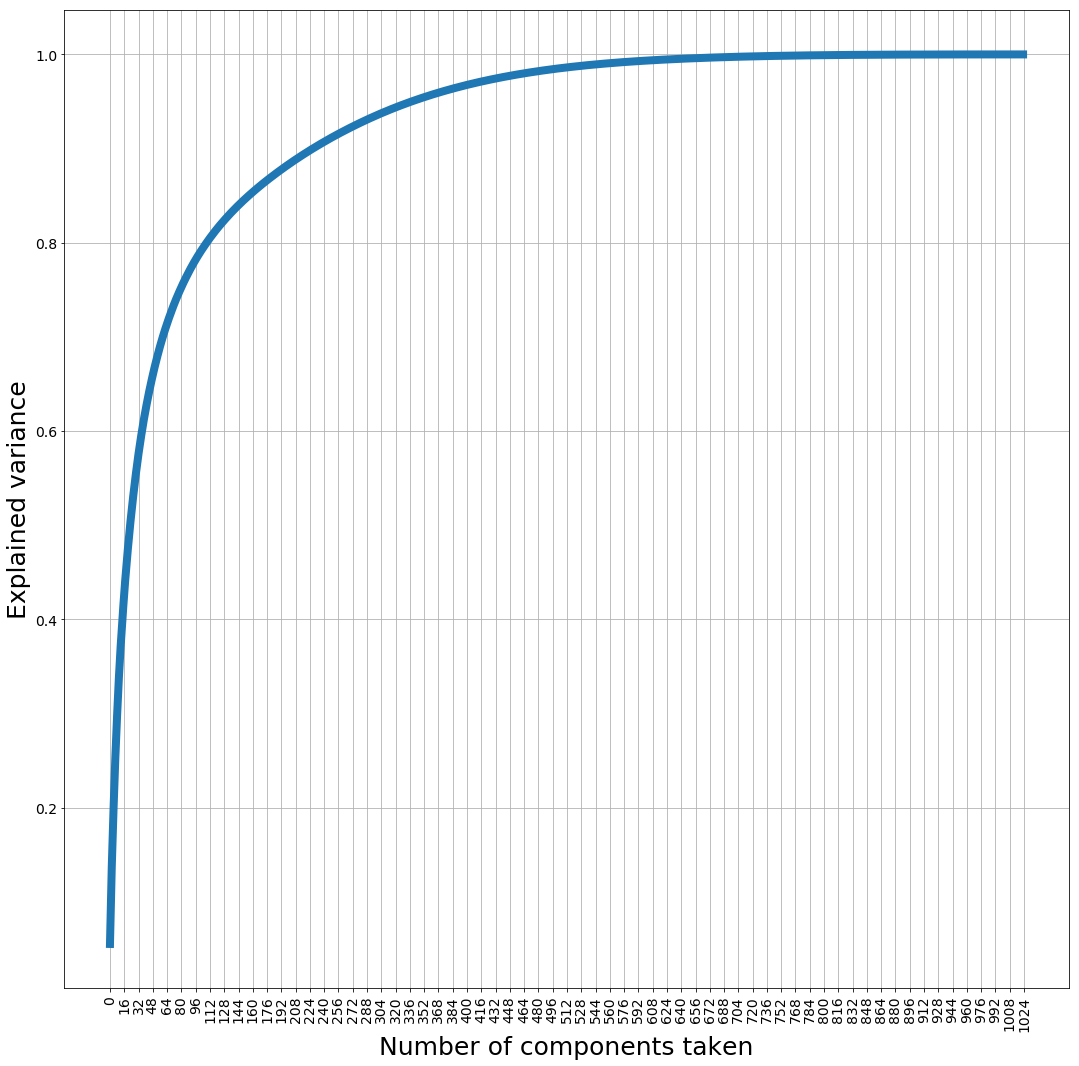

In [32]:
# Plotting the explained variance per number of components
plot_variances(explained, 'Number of components taken', 'Explained variance')

In [33]:
# Fitting the 10th degree polynomial# Fittin 
polynomial = np.polyfit(range(len(explained)), explained, 10)
poly = np.poly1d(polynomial)
derivative = poly.deriv()

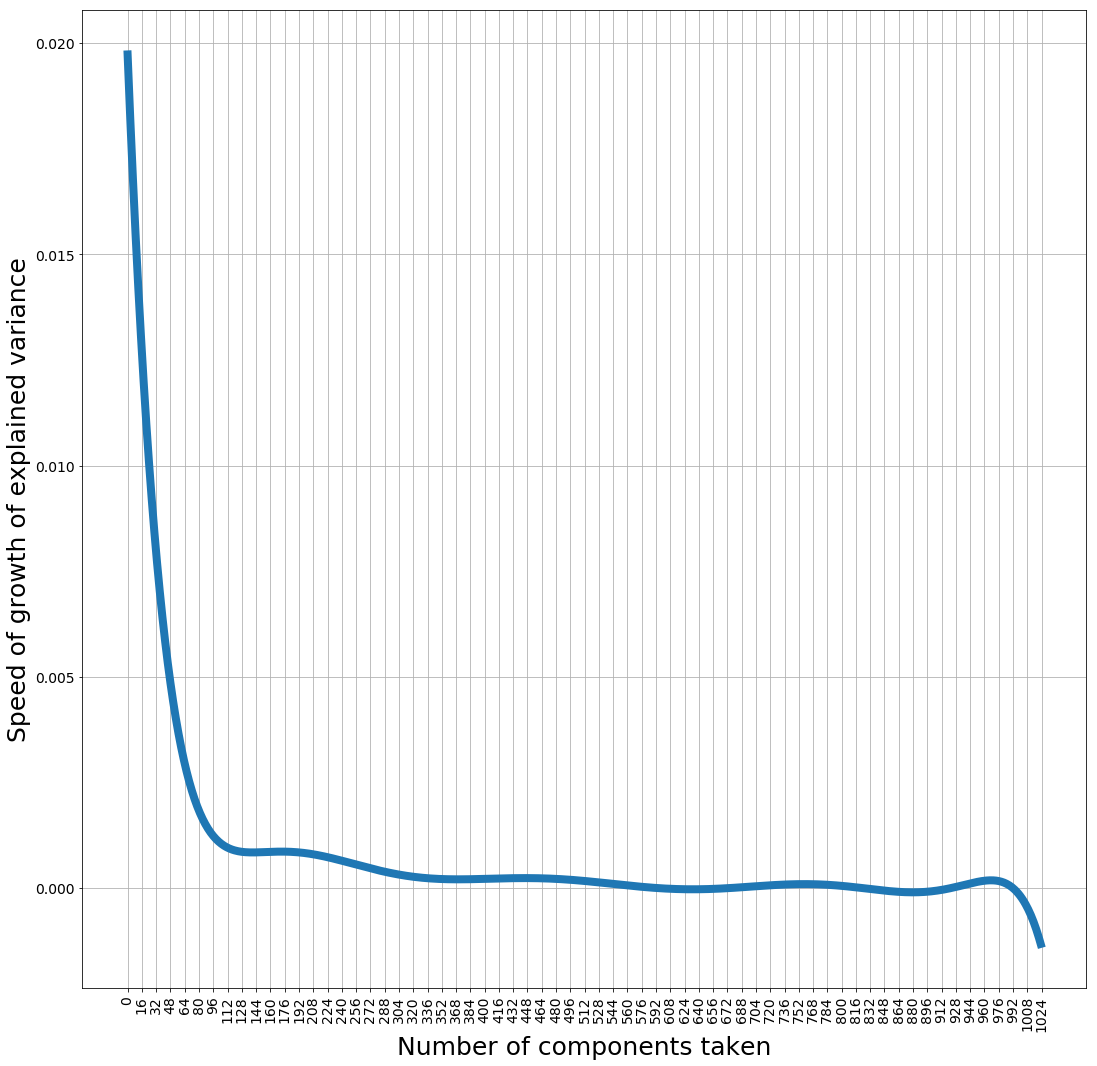

In [34]:
# Plotting the derivative
plot_variances(np.polyval(derivative, np.linspace(0, 1024, 1024)), 'Number of components taken', 
               'Speed of growth of explained variance')

In [35]:
# Projecting the data to the optimal 128 components maximizing the variance
transformation = PCA(n_components = 128)
X_proj = transformation.fit_transform(X)

# -----------------------------------------------------------------------------------------------------------
# Clustering 

In [36]:
# Clustering into 33 clusters
clusters = KMeans(n_clusters = 33, random_state = 2926).fit(X_proj)

In [37]:
# Labeling the data
labels = clusters.fit_predict(X_proj)

In [38]:
labels = labels.reshape(33, 180)

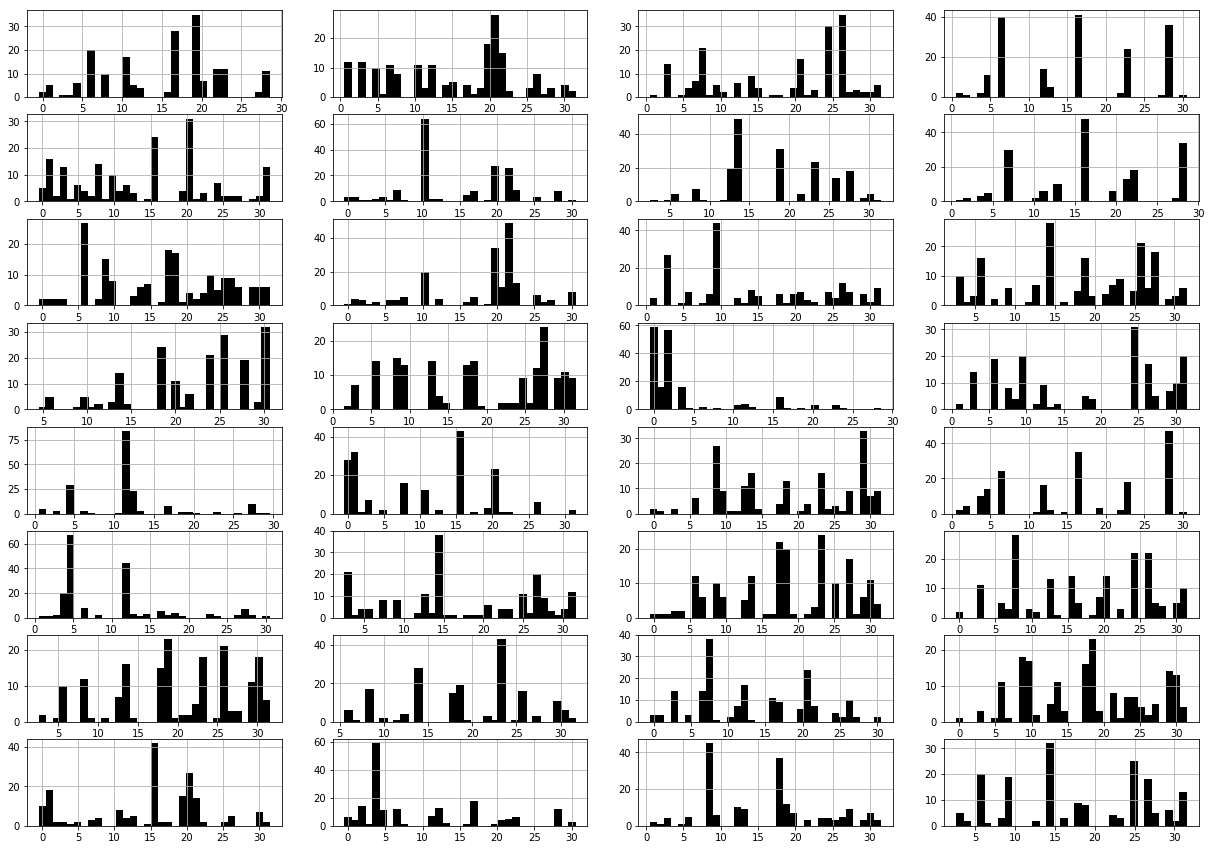

In [39]:
# Plotting histograms of the clusters
fig, ax = plt.subplots(nrows = 8, ncols = 4, figsize = (21, 15))
ind = 0
for row in ax:
    for col in row:
        ind+=1
        hist, bins = np.histogram(labels[ind], bins = 33)
        col.grid(True)
        col.bar(bins[:-1], hist, width = 1, color = 'k')

In [40]:
# Function to calculate the silhouette scores
def get_silhouette(X, n_clusters):
    clustering = KMeans(n_clusters = n_clusters, random_state = 2926)
    labels = clustering.fit_predict(X)

    return silhouette_score(X, labels, sample_size = 3000)

In [41]:
# Calculating the overal mean distances to the cluster centers for 2 to 33 clusters
silhoettes = map(lambda n_clusters: get_silhouette(X, n_clusters), range(2, 33))

In [42]:
# Function to plot the scores
def plot_metrics(scores, labels, x_label, y_label):
    fig, ax = plt.subplots(figsize = (18, 6))
    
    plots = ax.plot(labels, scores, linewidth = 5)
    plt.xlabel(x_label, fontsize = 22)
    plt.ylabel(y_label, fontsize = 22)
    plt.xticks(labels, fontsize = 15)
    plt.yticks(fontsize = 15)
    ax.grid(True)

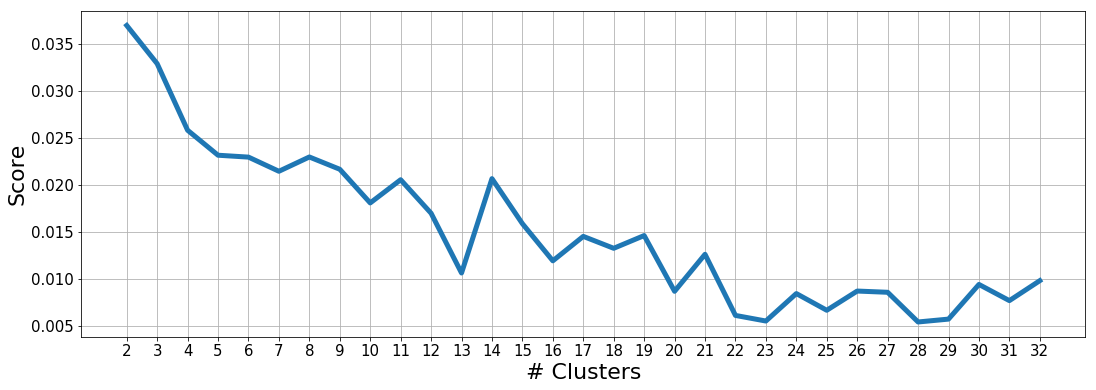

In [43]:
plot_metrics(silhoettes, range(2, 33), '# Clusters', 'Score')

# -----------------------------------------------------------------------------------------------------------
# Classification

In [44]:
# Creating labels for the images
labels = sum([[i]*180 for i in range(33)], [])

In [45]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig, ax = plt.subplots(figsize = (18, 17))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 21)
    plt.xlabel('Predicted label', fontsize = 21)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

In [46]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_proj, labels, test_size = 0.2, random_state = 2926)

## train-valid split
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state = 2926)

In [47]:
# The model
themodel = svm.SVC(kernel = 'poly', degree = 3).fit(X_train, y_train)
predictions = themodel.predict(X_test)

# model accuracy for X_test
accuracy = themodel.score(X_test, y_test)

# creating a confusion matrix
thematrix = confusion_matrix(y_test, predictions)

print "We predict the {} percent of test data".format((y_test == predictions).sum()*100/len(y_test))

We predict the 64 percent of test data


Normalized confusion matrix


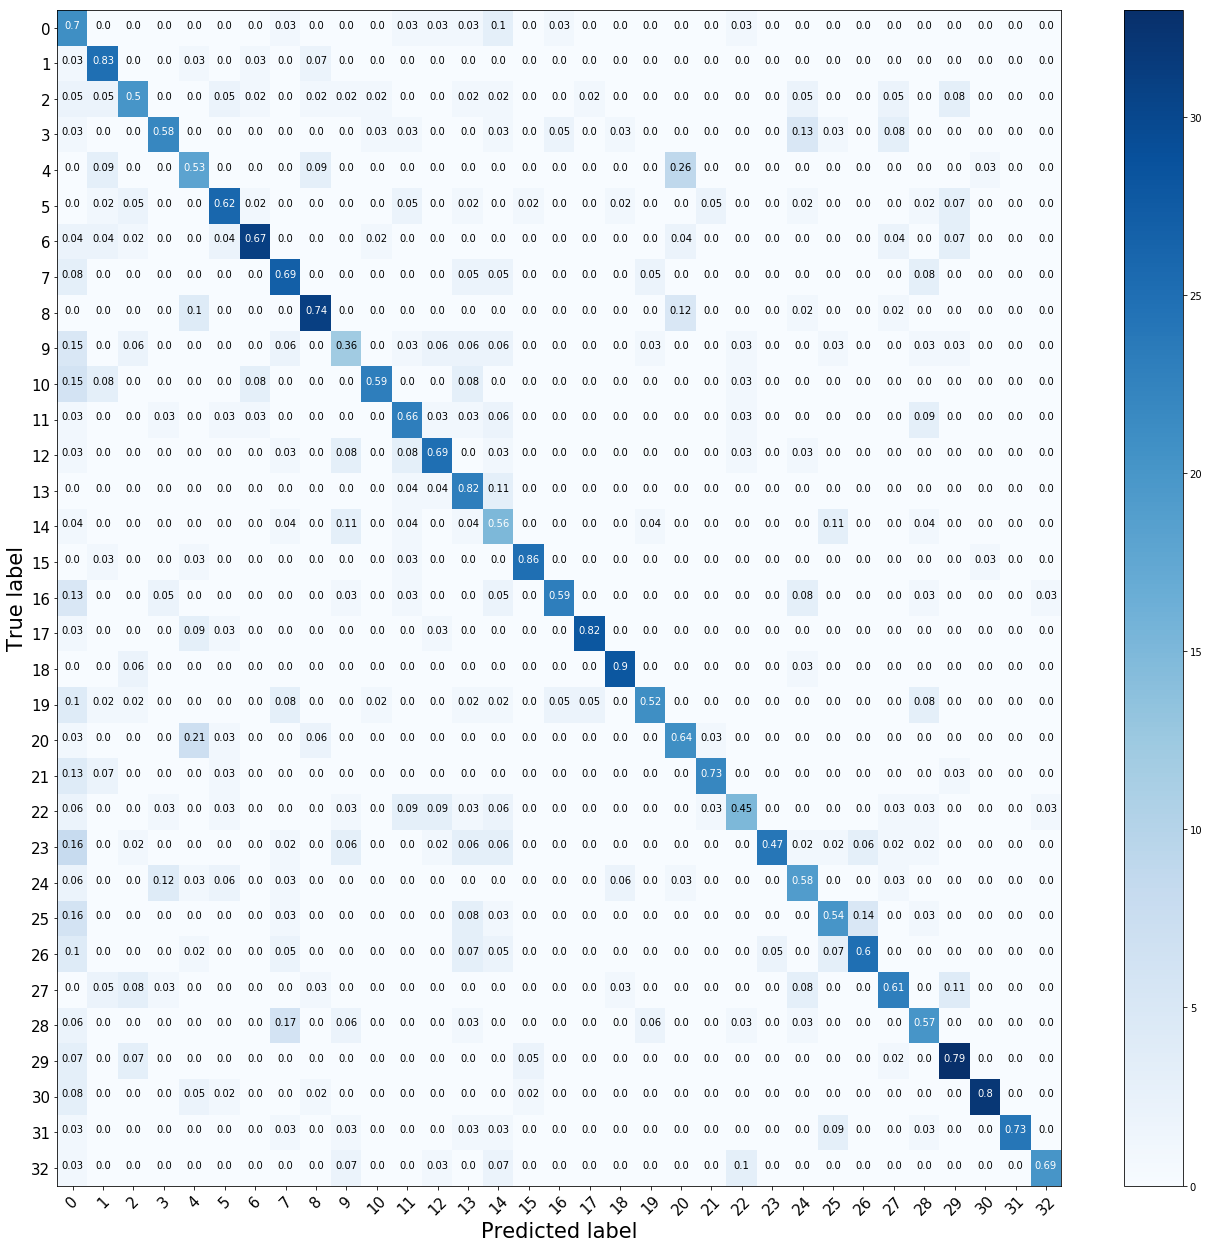

In [48]:
plot_confusion_matrix(thematrix, classes = map(str, range(33)), normalize = True, title='')